In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from pathlib import Path
import optuna
import numpy as np

from utils.data import load_config_xval_test_set, load_xval_test_set
from utils.analysis import xval_station_metrics, get_cdf
from utils.metrics import compute_metrics
from utils.plotting import load_default_mpl_config, savefig

load_default_mpl_config()

PLOT_PATH = Path('/mydata/machflow/basil/mach-flow/analysis/model_vis/')
runoff_vars = ['Qmm', 'Qmm_mod', 'Qmm_prevah']

def merged_df(mod, prevah):
    x_mod = mod.to_dataframe().reset_index()
    x_mod['source'] = 'mod'
    x_pre = prevah.expand_dims(dummy=1).to_dataframe().reset_index().drop(columns=['dummy'])
    x_pre['model'] = 'PREVAH'
    x_pre['source'] = 'prevah'
    x_both = pd.concat((x_mod, x_pre)).reset_index()

    return x_both

/mydata/machflow/basil/mambaforge/envs/machflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
xval_ds = xval_station_metrics(
    '/mydata/machflow/basil/runs/basin_level/',
    metrics=['nse', 'bias2', 'varerr', 'phaseerr'],
    time_slices=['1995,1999', '2016,2020'])

In [3]:
best_run = xval_ds.nse.median('station').argmax().compute()
best_run = xval_ds.run.isel(run=best_run).item()
best_run

'LSTM-staticall_allbasins_sqrttrans'

In [4]:
def run2label(run: str) -> str:

    config_names = []

    # Handle defaults.
    if 'static' not in run:
        config_names.append(r'S$_\mathrm{area}$')

    if 'allbasins' not in run:
        config_names.append(r'C$_\mathrm{98}$')

    if 'sqrttrans' not in run:
        config_names.append(r'T$_\mathrm{none}$')

    # Handle configs.
    PROPERTY2NAME = dict(
        staticall=r'S$_\mathrm{all}$',
        staticdred=r'S$_\mathrm{PCA}$',
        allbasins=r'C$_\mathrm{307}$',
        sqrttrans=r'T$_\mathrm{sqrt}$'
    )

    model, config = run.split('-')
    config_parts = config.split('_')


    for config_part in config_parts:
        config_names.append(PROPERTY2NAME.get(config_part, 'undefined'))

    config_name = ', '.join(config_names)

    return f'{model} ({config_name})'


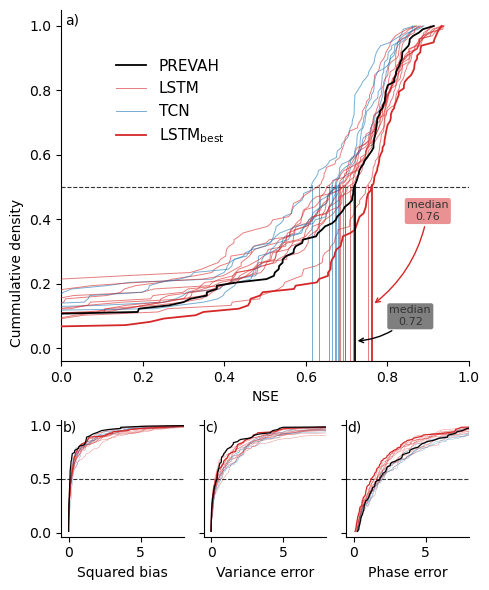

In [5]:
class ModelColors(object):
    def __init__(self, cmap: str = 'tab10'):
        self.cmap = plt.get_cmap(cmap)
        self.i = 0

    def __next__(self) -> tuple:
        color = self.cmap(self.i)
        self.i += 1
        return color

metrics = list(xval_ds.data_vars)
num_metrics = len(metrics)
ref = 'prevah'

# fig, axes = plt.subplots(
#     1, num_metrics, figsize=(5, 4), sharey='row', squeeze=False,
#     gridspec_kw={'hspace': 0.2})

import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize=(5, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1])

for i, metric in enumerate(metrics):

    if i == 0:
        ax = fig.add_subplot(gs[0, :])
    else:
        ax = fig.add_subplot(gs[1, i - 1])
        ax.set_xlim(-0.5, 8)

    da = xval_ds[metric]
    rel_metrics = da - da.sel(run=ref)
    lstm_colors = ModelColors(cmap='Paired')
    tcn_colors = ModelColors(cmap='Paired')

    for run in da.run.values:

        if run == ref:
            col = 'k'
            style = '-'
            zorder = 10
            lw = 1.3
            alpha = 1
            add_annot = 10
            label = 'PREVAH'
        else:
            zorder = 8
            lw = 0.7
            alpha = 0.6
            add_annot = 0
            if run.startswith('TCN'):
                # col = next(tcn_colors)
                # style = ':'
                col = 'tab:blue'
                style = '-'
                label = 'TCN'
            else:
                # col = next(lstm_colors)
                # style = '--'
                col = 'tab:red'
                style = '-'
                label = 'LSTM'

            if run == best_run:
                # col = 'tab:green'
                alpha = 1
                lw = 1.3
                zorder = 9
                add_annot = 60
                label = r'LSTM$_\mathrm{best}$'
                # label = f'CHRUN (best): {run2label(run)}'

        if i > 0:
            lw = lw - 0.4

        # CDF plots
        # ----------------
        # ax = axes[0, i]
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_xlabel(metric)

        bins, cdf, xloc = get_cdf(da.sel(run=run))

        ax.plot(bins, cdf, label=label, color=col, alpha=alpha, lw=lw, zorder=zorder,
                ls=style)

        if i == 0:
            ax.axvline(xloc, ymin=0, ymax=0.5, color=col, ls=style, alpha=alpha, lw=lw, zorder=zorder)

        if metric in ['nse', 'kge']:
            ax.set_xlim(0, 1)
        elif metric == 'absbias':
            ax.set_xlim(0, 2)

        annot_kwargs = dict(
            textcoords='offset points', ha='center', va='bottom', color='0.2',
            fontsize=8
        )

        if add_annot and i == 0:
            ax.annotate(
                f'median\n{xloc:0.2f}', xy=(xloc, add_annot / 450),
                xytext=(40,add_annot),
                bbox=dict(boxstyle='round,pad=0.2', fc=col, ec='none', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2', color=col, alpha=1.0),
                zorder=zorder,
                **annot_kwargs)

        if metric == 'nse':
            mname = 'NSE'
        elif metric == 'bias2':
            mname = 'Squared bias'
        elif metric == 'varerr':
            mname = 'Variance error'
        elif metric == 'phaseerr':
            mname = 'Phase error'
        else:
            mname = 'not defined (-)'
        ax.set_xlabel(mname)

    ax.axhline(0.5, color='0.2', ls='--', alpha=1.0, lw=0.8, zorder=0)

    if i == 0:
        ax.set_ylabel('Cummulative density', y=0.25)

        handles, labels = ax.get_legend_handles_labels()
        handle_list, label_list = [], []
        order = [1, 2, 3, 0]
        # order = [1, 2, 0]
        # order = [0, 1]
        for handle, label in zip(handles, labels):
            if label not in label_list:
                handle_list.append(handle)
                label_list.append(label)
        ax.legend(
            [handle_list[idx] for idx in order],
            [label_list[idx] for idx in order],
            frameon=False,
            fontsize=11,
            loc='upper left',
            bbox_to_anchor=(0.1, 0.9))

    if i > 1:
        ax.set_yticklabels([])

    ax.text(0.01, 0.99, ['a)', 'b)', 'c)', 'd)'][i], va='top', ha='left', transform=ax.transAxes)

savefig(fig, path=PLOT_PATH / 'model_comp.png')

/mydata/machflow/basil/mach-flow/utils/plotting.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


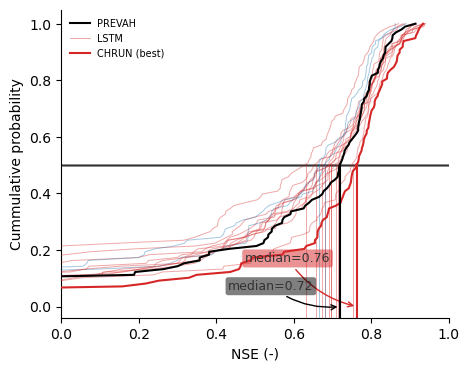

In [ ]:
class ModelColors(object):
    def __init__(self, cmap: str = 'tab10'):
        self.cmap = plt.get_cmap(cmap)
        self.i = 0

    def __next__(self) -> tuple:
        color = self.cmap(self.i)
        self.i += 1
        return color

metrics = list(xval_ds.data_vars)
num_metrics = len(metrics)
ref = 'prevah'

fig, axes = plt.subplots(
    1, num_metrics, figsize=(5, 4), sharey='row', squeeze=False,
    gridspec_kw={'hspace': 0.2})


for i, metric in enumerate(metrics):

    da = xval_ds[metric]
    rel_metrics = da - da.sel(run=ref)
    lstm_colors = ModelColors(cmap='Paired')
    tcn_colors = ModelColors(cmap='Paired')

    for run in da.run.values:

        if run == ref:
            col = 'k'
            style = '-'
            zorder = 10
            lw = 1.5
            alpha = 1
            add_annot = 10
            label = 'PREVAH'
        else:
            zorder = 8
            lw = 0.7
            alpha = 0.4
            add_annot = 0
            if run.startswith('TCN'):
                # col = next(tcn_colors)
                # style = ':'
                col = 'tab:blue'
                style = '-'
                label = 'TCN'
            else:
                # col = next(lstm_colors)
                # style = '--'
                col = 'tab:red'
                style = '-'
                label = 'LSTM'

            if run == best_run:
                # col = 'tab:green'
                alpha = 1
                lw = 1.5
                zorder = 9
                add_annot = 30
                label = f'CHRUN (best)'
                # label = f'CHRUN (best): {run2label(run)}'

        # CDF plots
        # ----------------
        ax = axes[0, i]
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_xlabel(metric)

        bins, cdf, xloc = get_cdf(da.sel(run=run))

        ax.plot(bins, cdf, label=label, color=col, alpha=alpha, lw=lw, zorder=zorder,
                ls=style)
        ax.axvline(xloc, ymin=0, ymax=0.5, color=col, ls=style, alpha=alpha, lw=lw, zorder=zorder)
        ax.axhline(0.5, color='0.2', ls=style, alpha=1.0, lw=0.8, zorder=0)

        if metric in ['nse', 'kge']:
            ax.set_xlim(0, 1)
        elif metric == 'absbias':
            ax.set_xlim(0, 2)

        annot_kwargs = dict(
            textcoords='offset points', ha='center', va='bottom', color='0.2',
            fontsize=9
        )

        if add_annot:
            ax.annotate(
                f'median={xloc:0.2f}', xy=(xloc, 0),
                xytext=(-50,add_annot),
                bbox=dict(boxstyle='round,pad=0.2', fc=col, ec='none', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color=col, alpha=1.0),
                zorder=zorder,
                **annot_kwargs)

        if metric == 'nse':
            mname = 'NSE (-)'
        else:
            mname = 'not defined (-)'

        ax.set_xlabel(mname)

axes[0, 0].set_ylabel('Cummulative probability')

handles, labels = axes[0, 0].get_legend_handles_labels()
handle_list, label_list = [], []
# order = [1, 2, 0, 3]
order = [1, 2, 0]
# order = [0, 1]
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
axes[0, 0].legend(
    [handle_list[idx] for idx in order],
    [label_list[idx] for idx in order],
    frameon=False,
    fontsize=7,
    loc='upper left',
    bbox_to_anchor=(0, 1))

savefig(fig, path=PLOT_PATH / 'model_comp.png')

In [18]:
def config_to_tune_path(df: pd.DataFrame) -> pd.DataFrame:

    for i in range(len(df)):
        el = df.iloc[i, :]

        s = []
        if el['static'] == 'all':
            s += ['staticall']
        elif el['static'] == 'dred':
            s += ['staticdred']

        if el['allbasins']:
            s += ['allbasins']

        if el['sqrttrans']:
            s += ['sqrttrans']

        if len(s) == 0:
            s = ['default']

        config = "_".join(s)
        model = el['model']

        optuna_path = f'sqlite:///../../runs/basin_level/{config}/{model}/tune/optuna.db'
        study = optuna.load_study(study_name=model, storage=optuna_path)

        for k, v in study.best_params.items():
            if k not in df.columns:
                df[k] = ''

            df.loc[i, k] = v

    return df

In [16]:
xval_ds = load_config_xval_test_set(
    path='/mydata/machflow/basil/runs/basin_level/',
    nonbool_kwords=['static'],
    time_slices=['1995,1999', '2016,2020']).drop_vars('tau').sel(model='LSTM')

met_ds = compute_metrics(
    obs=xval_ds.Qmm,
    mod=xval_ds.Qmm_mod,
    metrics='all',
    dim='time').median(dim='station').compute()

In [21]:
xval_df = met_ds.nse.to_dataframe().reset_index()
xval_df = config_to_tune_path(xval_df)

,allbasins,sqrttrans,static,model,nse,model_dim,enc_dropout,fusion_method,lstm_layers,lr,weight_decay
9,True,True,all,LSTM,0.762746,256,0.2,pre_encoded,1,0.001,0.01
6,True,False,all,LSTM,0.751392,256,0.2,pre_encoded,2,0.001,0.01
0,False,False,all,LSTM,0.714612,64,0.0,pre_encoded,2,0.01,0.001
11,True,True,none,LSTM,0.707821,64,0.2,post_repeated,1,0.001,0.1
7,True,False,dred,LSTM,0.696951,128,0.2,pre_encoded,1,0.001,0.01
1,False,False,dred,LSTM,0.695021,256,0.0,post_repeated,1,0.0001,0.01
10,True,True,dred,LSTM,0.690496,256,0.2,pre_encoded,2,0.001,0.01
8,True,False,none,LSTM,0.683429,64,0.2,pre_encoded,1,0.001,0.01
3,False,True,all,LSTM,0.681446,128,0.2,pre_encoded,1,0.01,0.1
4,False,True,dred,LSTM,0.671756,128,0.2,pre_encoded,2,0.01,0.01


In [112]:
xval_df_nice = xval_df.sort_values(by='nse', ascending=False).reset_index().drop(columns='index').rename(
    columns={
            'lr': 'learning_rate',
            'nse': 'NSE',
        }
    )
xval_df_nice['NSE'] = [f'{val:0.2f}' for val in xval_df_nice['NSE']]

In [117]:
nse_col = 'tab:gray'
mod_col = 'tab:olive'
opt_col = 'tab:pink'

col_props = {
    'NSE': nse_col,
    'allbasins': mod_col,
    'sqrttrans': mod_col,
    'static': mod_col,
    'model_dim': mod_col,
    'enc_dropout': mod_col,
    'fusion_method': mod_col,
    'lstm_layers': mod_col,
    'learning_rate':opt_col,
    'weight_decay': opt_col,
}

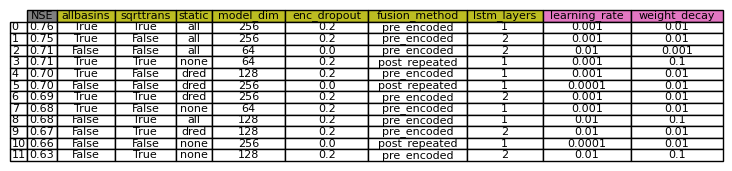

In [130]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.set_axis_off()

tab = pd.plotting.table(
    ax=ax,
    data=xval_df_nice[col_props.keys()],
    loc='center',
    cellLoc='center',
    colColours=list(col_props.values()),
    # edges='horizontal'
)

tab.auto_set_font_size(False)
tab.set_fontsize(8)
tab.auto_set_column_width(col=list(range(len(xval_df_nice[col_props.keys()].columns))))

savefig(fig, './model_vis/hp_table_lstm.pdf')

In [125]:
tab

In [9]:
xval_df = xval_df.replace({'fusion_method': {'pre_encoded': 'Prefusion (encode)', 'post_repeated': 'Postfusion (repeat)'}})
xval_df = xval_df.rename(columns={'fusion_method': 'Fusion method', 'model': 'Model'})

{'model_dim': 64, 'enc_dropout': 0.0, 'fusion_method': 'pre_encoded', 'lstm_layers': 2, 'lr': 0.01, 'weight_decay': 0.001}
{'model_dim': 64, 'enc_dropout': 0.2, 'fusion_method': 'pre_encoded', 'tcn_kernel_size': 8, 'tcn_layers': 3, 'tcn_dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.001}
{'model_dim': 256, 'enc_dropout': 0.0, 'fusion_method': 'post_repeated', 'lstm_layers': 1, 'lr': 0.0001, 'weight_decay': 0.01}


OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [7]:
xval_df_lstm = xval_df.loc[xval_df.Model == 'LSTM', :]
# xval_df_tcn = xval_df.loc[xval_df.Model == 'TCN', :]
xval_df_tcn = xval_df_lstm.copy()
xval_df_tcn['nse'] += np.random.normal(size=len(xval_df_tcn['nse'])) * 0.05

xval_df_lstm['nse'] -= xval_df_lstm['nse'].mean()
xval_df_tcn['nse'] -= xval_df_tcn['nse'].mean()


In [8]:
configs = [
    col for col in xval_df.columns if (not pd.api.types.is_numeric_dtype(xval_df[col]) or xval_df_lstm[col].dtypes == bool) and col not in ['Fusion method', 'Model']
]
configs

['allbasins', 'sqrttrans', 'static']

In [75]:
from scipy.linalg import lstsq



def plot_linear_fit(im, ax, vmin, vmax, cmap, return_z=False):

    if isinstance(im, list):
        Z_0 = plot_linear_fit(im[0], ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, return_z=True)
        im = im[1]
    else:
        Z_0 = None

    n_interp = 800
    xy = im.get_offsets().data
    xy_ = np.c_[xy, np.ones(xy.shape[0])]
    z = im.get_array().data
    C,_,_,_ = lstsq(xy_, z)

    xfactor = 0.05
    xmin, xmax = np.quantile(xy[:, 0], [0, 1])
    xr = (xmax - xmin) * xfactor
    xmin -= xr
    xmax += xr
    ymin, ymax = np.quantile(xy[:, 1], [0, 1])
    yr = (ymax - ymin) * xfactor
    ymin -= yr
    ymax += yr

    X = np.linspace(xmin, xmax, n_interp)
    Y = np.linspace(ymin, ymax, n_interp)
    X, Y = np.meshgrid(X, Y)
    Z = C[0] * X + C[1] * Y + C[2]

    if return_z:
        return Z

    if Z_0 is not None:
        replace_indices = np.tril_indices_from(Z)
        Z[replace_indices] = Z_0[replace_indices]

    ax.imshow(Z, vmin=vmin, vmax=vmax, extent=[xmin, xmax, ymax, ymin], aspect='auto', zorder=1, cmap=cmap)
    # ax.contourf(X, Y, Z)

In [76]:
def fix_label(label, ax, which):
    if label == 'allbasins':
        if which == 'x':
            ax.set_xlabel('Training\ncatchments')
            ax.set_xticks([0, 1])
            ax.set_xticklabels([r'C$_\mathrm{98}$', r'C$_\mathrm{307}$'])
        else:
            ax.set_ylabel('Training\ncatchments')
            ax.set_yticks([0, 1])
            ax.set_yticklabels([r'C$_\mathrm{98}$', r'C$_\mathrm{307}$'])

    if label == 'static':
        if which == 'x':
            ax.set_xlabel('Static\nvariables')
            ax.set_xticks([2, 1, 0])
            ax.set_xticklabels([r'S$_\mathrm{area}$', r'S$_\mathrm{PCA}$', r'S$_\mathrm{all}$'])
        else:
            ax.set_ylabel('Static\nvariables')
            ax.set_yticks([2, 1, 0])
            ax.set_yticklabels([r'S$_\mathrm{area}$', r'S$_\mathrm{PCA}$', r'S$_\mathrm{all}$'])

    if label == 'sqrttrans':
        if which == 'x':
            ax.set_xlabel('Target\ntransform')
            ax.set_xticks([0, 1])
            ax.set_xticklabels([r'T$_\mathrm{none}$', r'T$_\mathrm{sqrt}$'])
        else:
            ax.set_ylabel('Target\ntransform')
            ax.set_yticks([0, 1])
            ax.set_yticklabels([r'T$_\mathrm{none}$', r'T$_\mathrm{sqrt}$'])

/tmp/ipykernel_3813623/2142457870.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr_r', 31)
/mydata/machflow/basil/mach-flow/utils/plotting.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


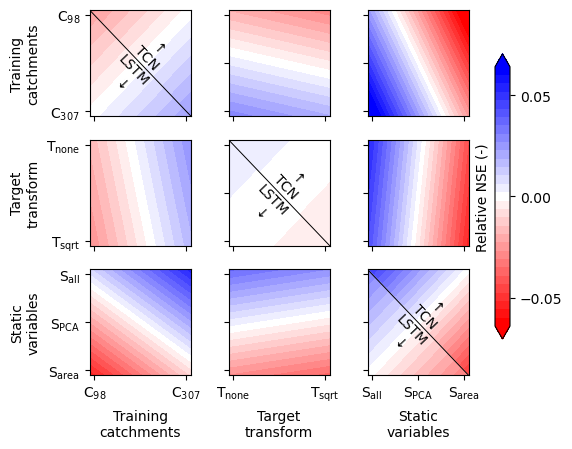

In [95]:
fig, axes = plt.subplots(len(configs), len(configs), figsize=(5, 4.6))

# cmap = 'coolwarm'
cmap = plt.cm.get_cmap('bwr_r', 31)

vmin, vmax = np.quantile(np.concatenate((xval_df_lstm.nse, xval_df_tcn.nse)), [0.1, 0.9])
vlim = max(np.abs(vmin), vmax)
vmin = -vlim
vmax = vlim

for c, cvar in enumerate(configs):
    for r, rvar in enumerate(configs):
        ax = axes[r, c]

        im0 = ax.scatter(x=cvar, y=rvar, c='nse', data=xval_df_lstm, edgecolor='k',
                        cmap=cmap, s=30, alpha=1, vmin=vmin, vmax=vmax, zorder=2)
        im1 = ax.scatter(x=cvar, y=rvar, c='nse', data=xval_df_tcn, edgecolor='k',
                        cmap=cmap, s=30, alpha=1, vmin=vmin, vmax=vmax, zorder=2)

        ax.cla()

        if c > r:
            plot_linear_fit(im1, ax, vmin=vmin, vmax=vmax, cmap=cmap)
        elif c == r:
            plot_linear_fit([im0, im1], ax, vmin=vmin, vmax=vmax, cmap=cmap)
        else:
            plot_linear_fit(im0, ax, vmin=vmin, vmax=vmax, cmap=cmap)


        if c == 0:
            fix_label(label=rvar, ax=ax, which='y')
        else:
            ax.set_yticklabels([])

        if r == len(configs) - 1:
            fix_label(label=cvar, ax=ax, which='x')
        else:
            ax.set_xticklabels([])

        if r == c:
            cline = ax.plot([0, 1], [1, 0], transform=ax.transAxes, color='k', lw=0.7, ls='-')

            ax.text(0.48, 0.48, 'LSTM\n' + r'$\downarrow$', rotation=-45,
                            horizontalalignment='center', verticalalignment='top',
                            transform_rotates_text=True, rotation_mode='anchor', transform=ax.transAxes)
            ax.text(0.51, 0.51, r'$\uparrow$' + '\nTCN', rotation=-45,
                            horizontalalignment='center', verticalalignment='bottom',
                            transform_rotates_text=True, rotation_mode='anchor', transform=ax.transAxes)

fig.align_labels(axes)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.25, 0.03, 0.62])
# fig.colorbar(im, cax=cbar_ax)

cbar = fig.colorbar(im0, cax=cbar_ax, extend='both', label='Relative NSE (-)')
cbar.ax.set_yticks([-0.05, 0, 0.05])
cbar.ax.yaxis.set_label_position('left')

savefig(fig, path=PLOT_PATH / 'interaction.png')


In [81]:
mod = compute_metrics(
    obs=xval_ds.Qmm,
    mod=xval_ds.Qmm_mod,
    metrics='all',
    dim='time').mean(dim='station').compute()
prevah = compute_metrics(
    obs=xval_ds.Qmm,
    mod=xval_ds.Qmm_prevah,
    metrics='all',
    dim='time').mean(dim='station').compute()

xr_df_mean = merged_df(mod, prevah)

<Axes: xlabel='model', ylabel='bias2'>

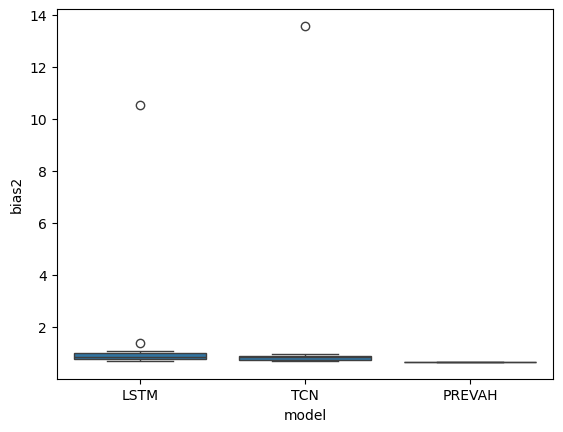

In [89]:
sns.boxplot(x='model', y='bias2',data=xr_df_mean)

In [ ]:

fig, axes = plt.subplots(
    1, len(configs), figsize=(6, 3), sharex='col', sharey='row',
    gridspec_kw={'wspace': 0.25})

for c, cvar in enumerate(configs):
    ax = axes[c]
    
    im = sns.scatterplot(
        x=cvar,
        y='nse',
        data=xval_df,
        hue='Fusion method',
        style='Model',
        legend=c==1,
        markers=['o', '^'],
        edgecolor='k',
        s=25,
        ax=ax,
    )

    if c == 1:
        sns.move_legend(
            ax, "lower center",
            bbox_to_anchor=(0.5, 1), ncol=2, title=None, frameon=False,
        )

    data = ax.collections[0].get_offsets().data
    n_x = len(np.unique(data[:, 0]))

    for i in range(n_x - 1):
        data0 = data[np.argwhere(data[:, 0] == i)[:, 0], :]
        data1 = data[np.argwhere(data[:, 0] == i + 1)[:, 0], :]

        for l in range(data0.shape[0]):
            ax.plot([data0[l][0], data1[l][0]], [data0[l][1], data1[l][1]], color='k', lw=0.5, ls='-', zorder=-1)

    # axc = ax.collections
    # for a in axc[::2]:
    #     a.set_paths([triangle_up_mk])
    # for a in axc[1::2]:
    #     a.set_paths([square_mk])

    # if c==1:
    #     ax.legend(axc[-2:], pd.unique(xval_df.model),
    #         loc='lower center',
    #         bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False,)

    # for i in range(len(ax.collections) - 1):
    #     coll0 = ax.collections[i].get_offsets().data
    #     coll1 = ax.collections[i + 1].get_offsets().data

    #     for l in range(coll0.shape[0]):
    #         ax.plot([coll0[l][0], coll1[l][0]], [coll0[l][1], coll1[l][1]], color='k', lw=1, ls='-')


    ax.set_xlabel(cvar)

    if c == 0:
        ax.set_ylabel('NSE')
    else:
        ax.set_ylabel('')

    ax.set_xlabel(ax.get_xlabel().capitalize())

savefig(fig, path=PLOT_PATH / 'model_factors.png')

/mydata/machflow/basil/mach-flow/utils/plotting.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


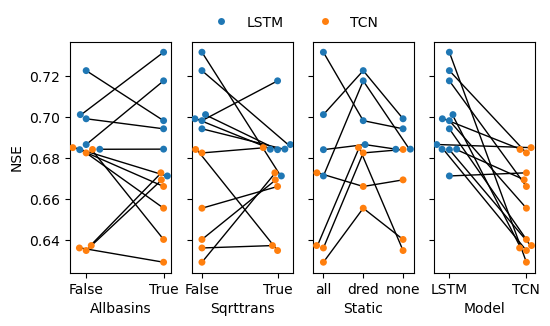

In [ ]:

fig, axes = plt.subplots(
    1, len(configs), figsize=(6, 3), sharex='col', sharey='row',
    gridspec_kw={'wspace': 0.2})

for c, cvar in enumerate(configs):
    ax = axes[c]

    ax = sns.swarmplot(
        x=cvar,
        y='nse',
        data=xval_df,
        dodge=False,
        hue='model',
        legend=c==1,
        ax=ax,
        )

    if c == 1:
        sns.move_legend(
            ax, "lower center",
            bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False,
        )

    for i in range(len(ax.collections) - 1):
        coll0 = ax.collections[i].get_offsets().data
        coll1 = ax.collections[i + 1].get_offsets().data

        for l in range(coll0.shape[0]):
            ax.plot([coll0[l][0], coll1[l][0]], [coll0[l][1], coll1[l][1]], color='k', lw=1, ls='-')

    ax.set_xlabel(cvar)

    if c == 0:
        ax.set_ylabel('NSE')
    else:
        ax.set_ylabel('')

    ax.set_xlabel(ax.get_xlabel().capitalize())

savefig(fig, path=PLOT_PATH / 'model_factors.png')

Text(0.5, 24.0, 'Model')

In [2]:
xval_ds = load_config_xval_test_set(
    path='/mydata/machflow/basil/runs/basin_level/', nonbool_kwords=['static']).drop_vars('tau')
met_ds = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_mod, metrics='all', dim='time')
met_ds_p = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_prevah, metrics='all', dim='time')
met_ds_glob = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_mod, metrics=['mse'], dim=None)
met_ds_glob_p = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_prevah, metrics=['mse'], dim=None)

In [19]:
best_ds = load_xval_test_set('../../runs/basin_level/default/LSTM/xval/')[runoff_vars].sel(tau=0.5).drop_vars('tau')
met_ds_best = compute_metrics(best_ds.Qmm, mod=best_ds.Qmm_mod, dim='time')
met_ds_best_p = compute_metrics(best_ds.Qmm, mod=best_ds.Qmm_prevah, dim='time')

In [23]:
all_metrics = list(met_ds_best.data_vars)
x_mod = met_ds_best.to_dataframe().reset_index()
x_mod['source'] = 'mod'
x_pre = met_ds_best_p.to_dataframe().reset_index()
x_pre['source'] = 'prevah'
x_both = pd.concat((x_mod, x_pre))

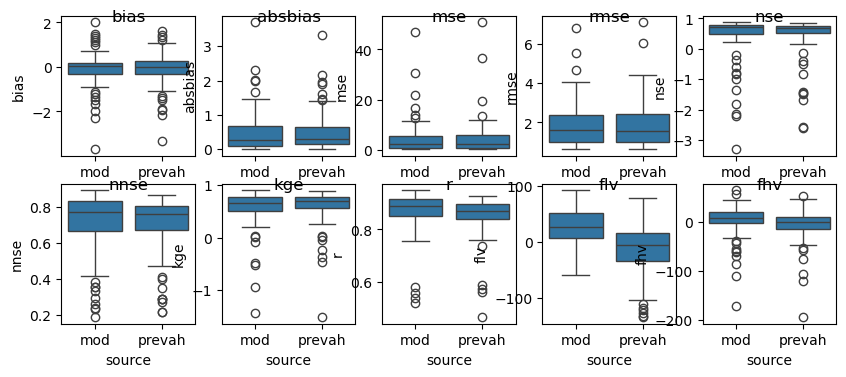

In [24]:
n = len(all_metrics)

n_cols = n // 2
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i, metric in enumerate(all_metrics):
    ax = axes.flatten()[i]
    sns.boxplot(x='source', y=metric, data=x_both, ax=ax)
    ax.set_title(metric, y=0.9)